# Optimización del diseño energético en edificios

1. [Análisis exploratorio de los datos](#1-análisis-exploratorio-de-los-datos)

2. [Preprocesamiento](#2-preprocesamiento)

3. [Algoritmo de Machine Learning (LR vs XG Boost Regressor)](#3-algoritmo-de-machine-learning)
 - 2.1. [Linear Regression](#31-linear-regression)
 - 2.2. [XG Boost Regressor](#32-xg-boost-regressor)

4. [Conclusiones](#4-conclusiones)

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# 1. Análisis exploratorio de los datos

In [2]:
# Mostrar todas las columnas del df
pd.set_option('display.max_columns', None)

In [3]:
# Importar DataFrame
df = pd.read_excel('./data/ENB2012_data.xlsx')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
df.columns=["relative_compactness","surface_area","wall_area","roof_area","overall_height","orientation", "glazing_area","glazing_area_dist",
            "heating_load","cooling_load"]
df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_dist,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   relative_compactness  768 non-null    float64
 1   surface_area          768 non-null    float64
 2   wall_area             768 non-null    float64
 3   roof_area             768 non-null    float64
 4   overall_height        768 non-null    float64
 5   orientation           768 non-null    int64  
 6   glazing_area          768 non-null    float64
 7   glazing_area_dist     768 non-null    int64  
 8   heating_load          768 non-null    float64
 9   cooling_load          768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


La información que nos muestra es que no hay valores nulos y todos los datos son numéricos. Hay un total de 768 filas y 9 columnas. 

In [6]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
relative_compactness,768.0,0.76,0.11,0.62,0.68,0.75,0.83,0.98
surface_area,768.0,671.71,88.09,514.50,606.38,673.75,741.12,808.50
wall_area,768.0,318.50,43.63,245.00,294.00,318.50,343.00,416.50
roof_area,768.0,176.60,45.17,110.25,140.88,183.75,220.50,220.50
overall_height,768.0,5.25,1.75,3.50,3.50,5.25,7.00,7.00
orientation,768.0,3.50,1.12,2.00,2.75,3.50,4.25,5.00
glazing_area,768.0,0.23,0.13,0.00,0.10,0.25,0.40,0.40
glazing_area_dist,768.0,2.81,1.55,0.00,1.75,3.00,4.00,5.00
heating_load,768.0,22.31,10.09,6.01,12.99,18.95,31.67,43.10
cooling_load,768.0,24.59,9.51,10.90,15.62,22.08,33.13,48.03


In [7]:
# Revisamos si hay valores duplicados
df.duplicated().sum()

0

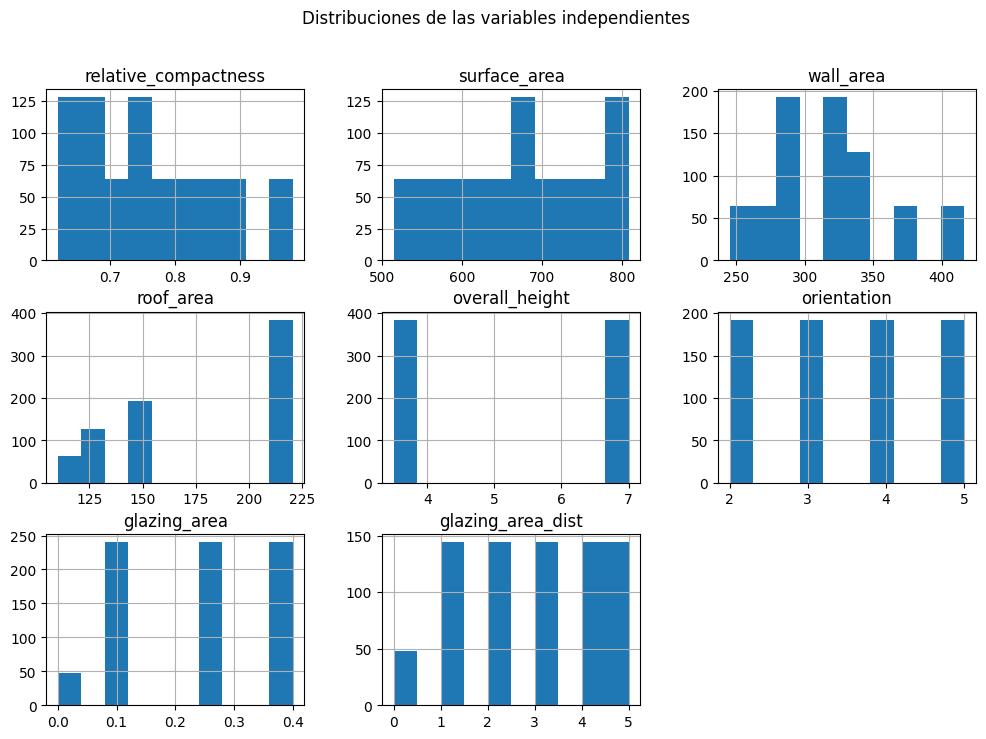

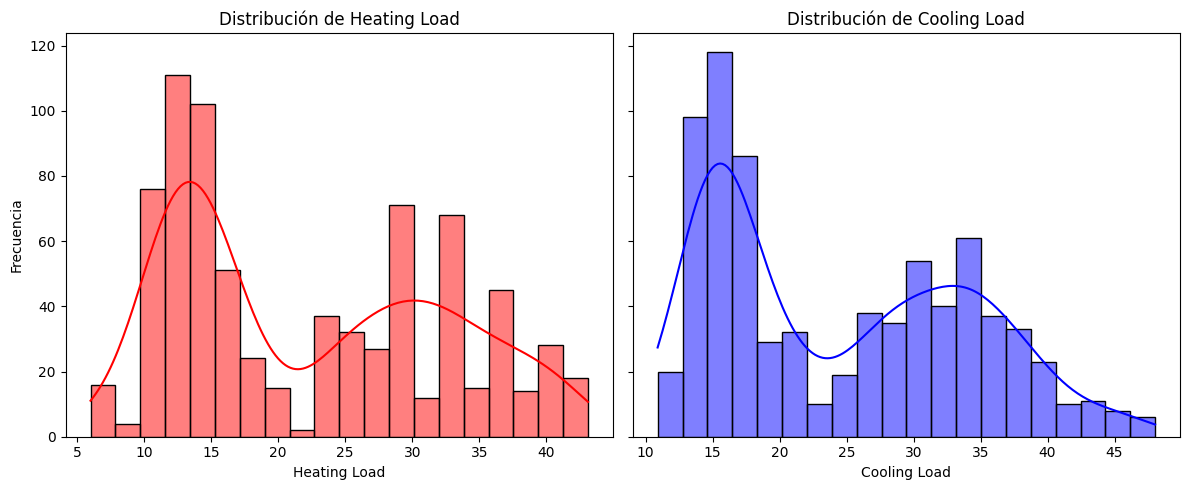

In [8]:
# Variables independientes
features = ["relative_compactness","surface_area","wall_area","roof_area","overall_height","orientation", "glazing_area","glazing_area_dist"]
df[features].hist(figsize=(12, 8))
plt.suptitle('Distribuciones de las variables independientes')
plt.show()

# Variables objetivo
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Gráfico de Heating Load
sns.histplot(df['heating_load'], kde=True, bins=20, color='red', ax=axes[0])
axes[0].set_title('Distribución de Heating Load')
axes[0].set_xlabel('Heating Load')
axes[0].set_ylabel('Frecuencia')

# Gráfico de Cooling Load
sns.histplot(df['cooling_load'], kde=True, bins=20, color='blue', ax=axes[1])
axes[1].set_title('Distribución de Cooling Load')
axes[1].set_xlabel('Cooling Load')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

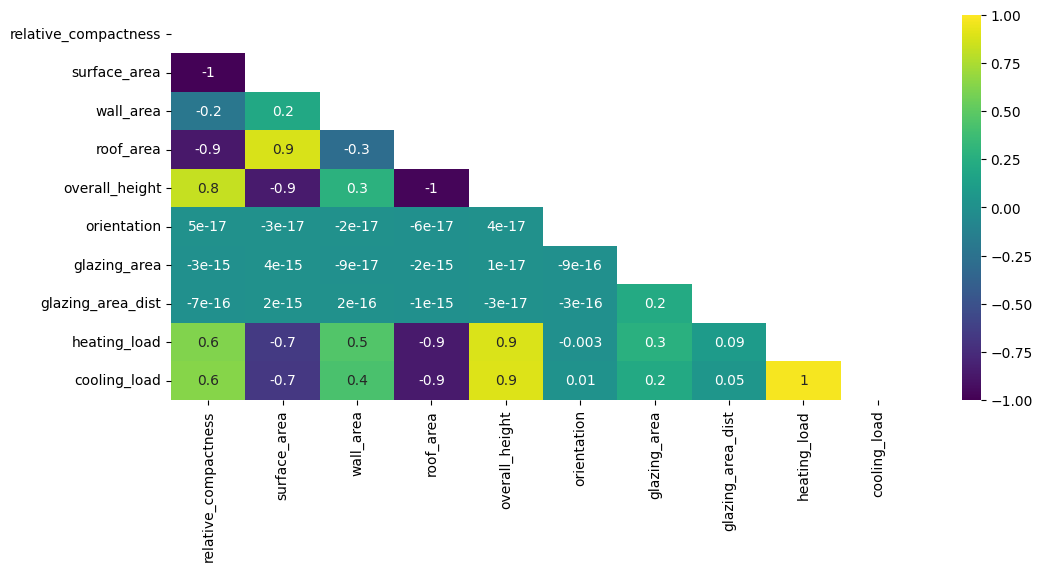

In [9]:
# Correlación de variables
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype = np.bool_))

plt.figure(figsize=(12,5))
sns.heatmap(df.corr(),
            annot = True, 
            vmin=-1,
            vmax=1,
            cmap="viridis",
            linecolor="black", 
            fmt='.1g',
            mask=mask);

Ambas variables objetivo ('heating_load' y 'cooling_load') tienen una fuerte correlación positiva (0.9) con la variable 'overall_height' y una correlación positiva moderada (0.6) con 'relative_compactness'. 
Por otro lado, poseen una fuerte correlación negativa (-0.9) con 'roof_area' y 'surface_area' (-0.7).

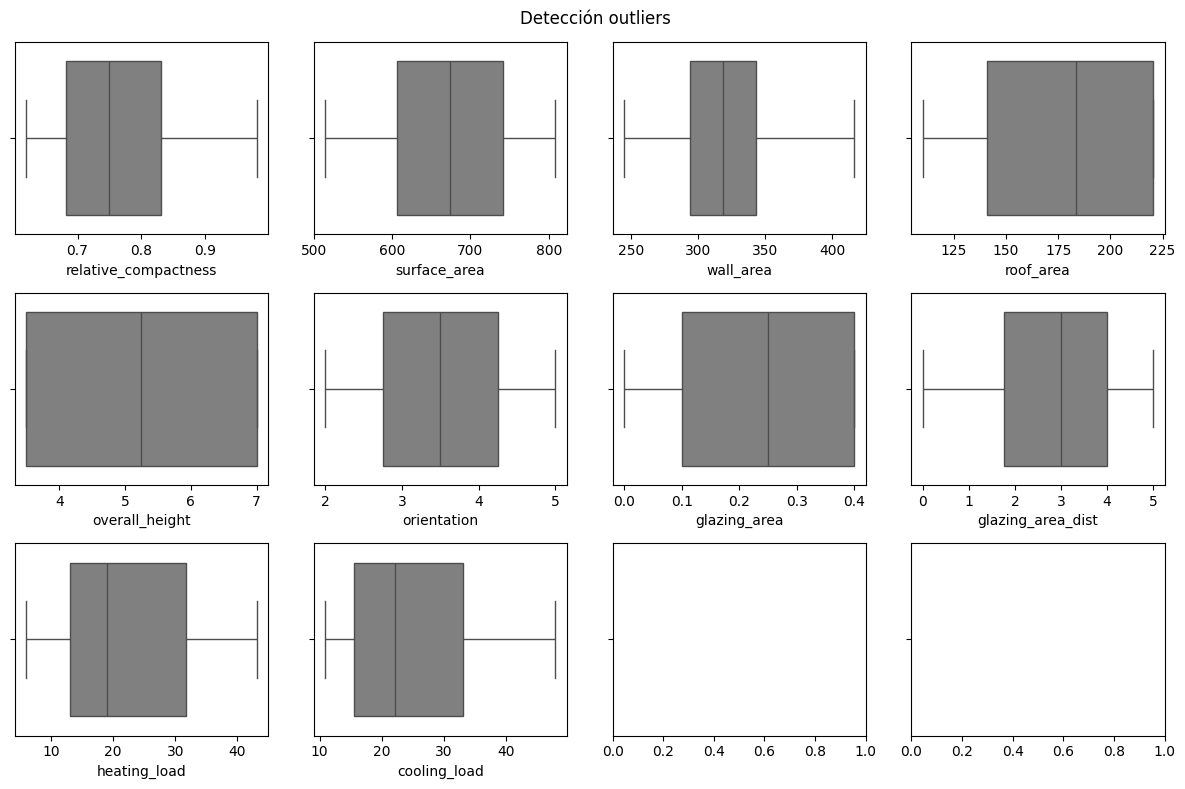

In [10]:
# Detección de outliers

lista_num = df.select_dtypes(include=['number']).columns

# Crear los subgráficos (axes)
fig, axes = plt.subplots(nrows=3, 
                         ncols=math.ceil(len(lista_num) / 3), 
                         figsize=(12, 8), 
                         sharey=True)

axes = axes.flat  # Convertir 'axes' en un arreglo unidimensional para iterar

# Graficar los histogramas
for indice, columna in enumerate(lista_num):
    sns.boxplot(x=columna, 
                data=df, 
                ax=axes[indice], 
                color='grey', 
                flierprops={'markersize': 4, 'markerfacecolor': 'blue'})

# Título de la figura
plt.suptitle("Detección outliers")

# Ajustar el diseño para que no se sobrepongan los elementos
plt.tight_layout()
plt.show();

No se observan puntos fuera de los bigotes en ninguno de los boxplots, lo que sugiere que no hay outliers evidentes en el dataset para estas variables.

# 2. Preprocesamiento

In [11]:
# Variables independientes
X = df[features]
X.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_dist
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


In [12]:
# Variable dependiente. Utilizamos en este caso 'cooling_load'
y = df[['cooling_load']]
y.head()

,cooling_load
0,21.33
1,21.33
2,21.33
3,21.33
4,28.28


In [13]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Algoritmo de Machine Learning

## 3.1 Linear Regression

In [14]:
# Entrenamiento del modelo de Regresión Lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

In [15]:
# Evaluación
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimimos valores
print(f'R²: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

R²: 0.89
MAE: 2.20
RMSE: 3.15


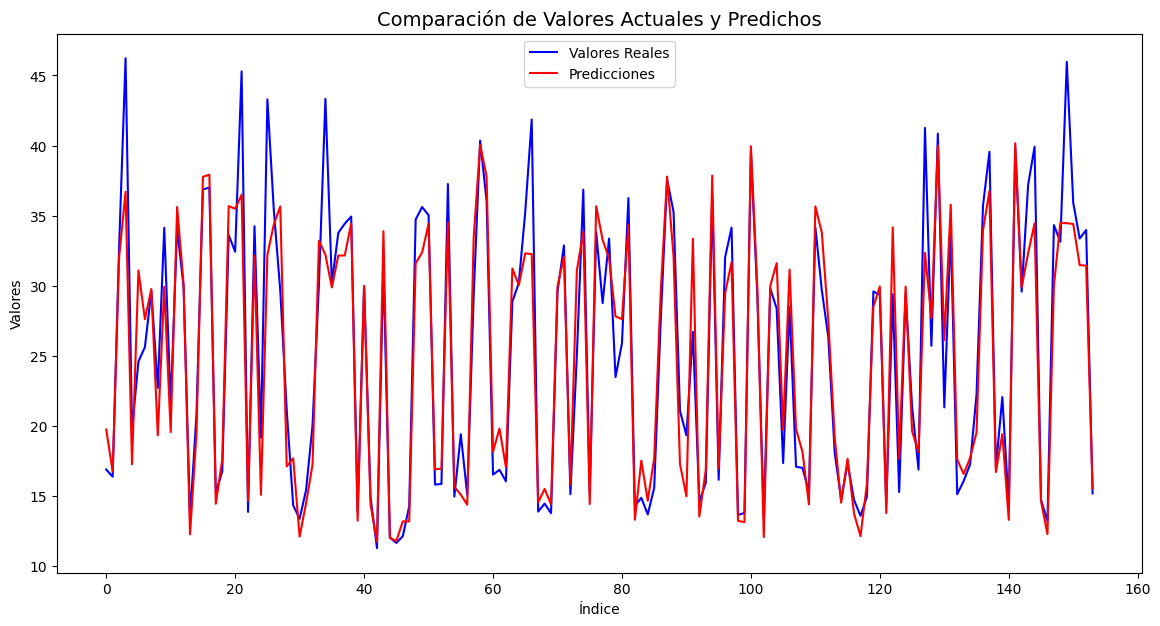

In [16]:
# Visualización: valores reales vs predicciones

actual = y_test.reset_index(drop=True)
plt.figure(figsize = (14,7))
plt.plot(actual, label='Valores Reales', color='blue')
plt.plot(y_pred, label='Predicciones', color='red')
plt.legend()
plt.xlabel("Índice")
plt.ylabel("Valores")
plt.title('Comparación de Valores Actuales y Predichos', fontsize=14)
plt.show()

<div style="background-color: grey; padding: 10px; border-left: 6px solid #000000; color: black; border-radius: 10px;">
<h5>Interpretación de los resultados en Linear Regression:</h5>

El valor de R² en éste método es del 0.89. Esto sugiere que el modelo tiene un buen desempeño, ya que está explicando una gran proporción de la variabilidad.

## 3.2 XG Boost Regressor

In [17]:
# Definimos los parámetros a evaluar
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 600],  # Probar distintos números de árboles
    'max_depth': [3, 5, 7],  # También puedes ajustar otros parámetros
    'learning_rate': [0.1, 0.05, 0.01], # Probar distintas tasas de aprendizaje
    'subsample': [0.8, 1.0],  # Fracción de muestras utilizadas por cada árbol
    'colsample_bytree': [0.8, 1.0]  # Fracción de características utilizadas por árbol
}

# Creamos el modelo base
xgb_r = XGBRegressor(random_state=42)

# Configuramos GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_r,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # Validación cruzada de 5 folds
    verbose=1
)

# Ejecutamos la búsqueda
grid_search.fit(X_train, y_train)

# Imprimimos los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.8}


In [18]:
# Entrenamos el modelo con los mejores hiperparámetros
best_xgb_r = XGBRegressor(**best_params, random_state=42)
best_xgb_r.fit(X_train, y_train)

# Realizar predicciones
y_pred = best_xgb_r.predict(X_test)

In [19]:
# Calculamos métricas de evaluación
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimimos métricas
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.99
MAE: 0.46
RMSE: 0.83


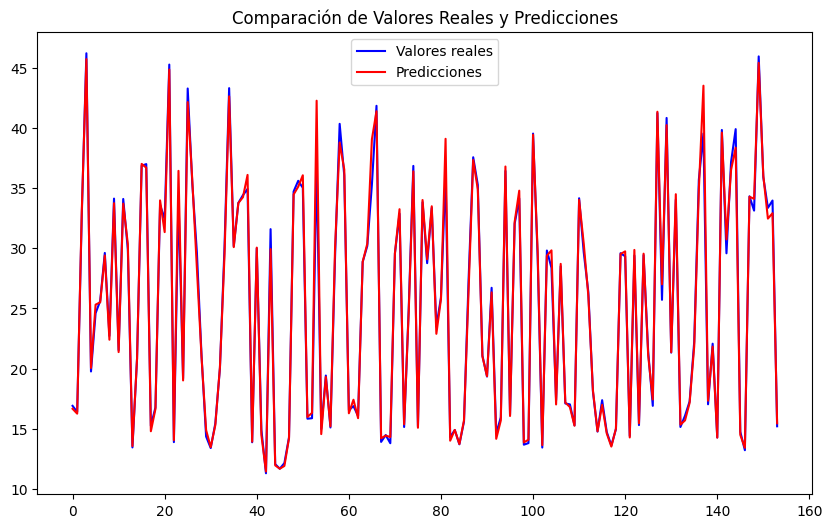

In [20]:
# Visualización: valores reales vs predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores reales', color='blue')
plt.plot(y_pred, label='Predicciones', color='red')
plt.legend()
plt.title('Comparación de Valores Reales y Predicciones')
plt.show()

# 4. Conclusiones

<div style="background-color: grey; padding: 10px; border-left: 6px solid #000000; color: black; border-radius: 10px;">
<h5>Conclusión</h5>

Basándonos en los resultados obtenidos, optamos por el modelo **XG Boost Regressor** como el mejor para predecir la carga de refrigeración de los edificios, ya que arrojó un valor R² de **0.99** frente a los 0.89 del modelo Linear Regression. Además, el MAE (Error Absoluto Medio) se reduce significativamente, así como el RMSE.

<div style="background-color: grey; padding: 10px; border-left: 6px solid #000000; color: black; border-radius: 10px;">
<h5>Uso práctico del modelo:</h5>

Este modelo se puede utilizar para optimizar el diseño energético en edificios, ya que permite evaluar propuestas de diseño antes de construir. 
Introduciendo los valores específicos, se pueden obtener predicciones para las necesidades de refrigeración. Por ejemplo:

In [21]:
nuevo_diseño = {
    'relative_compactness': 0.8,
    'surface_area': 680,
    'wall_area': 310,
    'roof_area': 200,
    'overall_height': 5,
    'orientation': 2,
    'glazing_area': 0.1,
    'glazing_area_dist': 3
}
nuevo_diseño_df = pd.DataFrame([nuevo_diseño])
pred_cooling = best_xgb_r.predict(nuevo_diseño_df)
print(f"Predicción de Cooling Load: {pred_cooling[0]:.2f}")

Predicción de Cooling Load: 38.79
